<a href="https://colab.research.google.com/github/aarsanjani/meansquares/blob/master/Clustering_withGMMIntermediateFractual.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# K-means 

In [2]:
import pandas as pd

import pandas as pd
#import wget 
from PIL import Image

from tqdm import tqdm
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

import seaborn as sns
import os
from pandas import Series, datetime
from pandas.plotting import scatter_matrix, autocorrelation_plot
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.model_selection import train_test_split, KFold, cross_val_score, GridSearchCV, TimeSeriesSplit
from sklearn import metrics
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, mean_squared_error
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.cluster import KMeans
from sklearn.svm import SVC
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier, RandomForestClassifier, ExtraTreesClassifier
from sklearn.metrics import roc_curve, auc
import random
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima_model import ARIMA
from xgboost import XGBClassifier
from sklearn.mixture import GaussianMixture
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn import preprocessing
from sklearn.metrics import silhouette_score





/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [5]:
!ls '/content/drive/Shared drives/CMPE 295- Master Project/Covid19-data/Maryland_Inertia_Data'

6Sates_Mobility_ClusterAnalysis.ipynb
6States_labeling_CDC_Guideline.ipynb
6states_sd_inertia_labeledData_CDC_Guideline_Nov03.csv
county_all_15Dec.zip
county_inertia_dec15.csv
County_Oct13.csv
County.zip
Maryland_inertia_clusterlabeled_Oct20.csv
Maryland_inertia_clusterlabeled_Oct23.csv
Maryland_inertia_MobilityCluster_Oct24.csv
Maryland_inertia_testingCluster_Oct24.csv


In [41]:
maryland_sd_inertia = pd.read_csv('/content/drive/Shared drives/CMPE 295- Master Project/Covid19-data/Maryland_Inertia_Data/county_inertia_dec15.csv',low_memory=False)
maryland_sd_inertia.head()

,CTFIPS,CTNAME,STFIPS,Social.distancing.index,X..staying.home,Trips.person,X..out.of.county.trips,X..out.of.state.trips,Miles.person,Work.trips.person,Non.work.trips.person,New.COVID.cases,Population,X..change.in.consumption,date,Transit.mode.share,X..people.older.than.60,Median.income,X..African.Americans,X..Hispanic.Americans,X..Male,Population.density,Employment.density,X..hot.spots.1000.people,Hospital.beds.1000.people,ICUs.1000.people,X..contact.tracing.workers.1000.people,New.cases.1000.people,Active.cases.1000.people,X.days..decreasing.COVID.cases,X..hospital.bed.utilization,Testing.capacity,Tests.done.1000.people,X..ICU.utilization,Ventilator.shortage,Imported.COVID.cases,COVID.exposure.1000.people,X.days..decreasing.ILI.cases,Unemployment.claims.1000.people,Unemployment.rate,X..working.from.home,Cumulative.inflation.rate,COVID.death.rate
0,1001,Autauga County,1,54,27,2.25,38.8,1.2,24.7,0.25,2.00,0,55601,-22.5,01/01/2020,0.11,19,58786,19.0,2.8,48.68,91,19,101,3.79,0.33,0.025,0.0,0.0,0,47.1,0.0,0.0,0.0,0,0,0.0,0,0.9,2.7,3.2,0.3,0.0
1,1001,Autauga County,1,25,18,2.83,43.5,0.9,37.6,0.62,2.21,0,55601,-14.3,01/02/2020,0.11,19,58786,19.0,2.8,48.68,91,19,101,3.79,0.33,0.025,0.0,0.0,0,47.1,0.0,0.0,0.0,0,0,0.0,0,0.9,2.7,3.2,0.3,0.0
2,1001,Autauga County,1,15,15,3.18,42.2,1.0,40.3,0.62,2.57,0,55601,-0.4,01/03/2020,0.11,19,58786,19.0,2.8,48.68,91,19,101,3.79,0.33,0.025,0.0,0.0,0,47.1,0.0,0.0,0.0,0,0,0.0,0,0.9,2.7,3.2,0.3,0.0
3,1001,Autauga County,1,33,20,2.85,43.9,1.2,29.5,0.33,2.52,0,55601,-2.3,01/04/2020,0.11,19,58786,19.0,2.8,48.68,91,19,101,3.79,0.33,0.025,0.0,0.0,0,47.1,0.0,0.0,0.0,0,0,0.0,0,0.9,2.7,3.2,0.3,0.0
4,1001,Autauga County,1,40,22,2.56,42.8,1.2,30.9,0.23,2.33,0,55601,-9.7,01/05/2020,0.11,19,58786,19.0,2.8,48.68,91,19,101,3.79,0.33,0.025,0.0,0.0,0,47.1,0.0,0.0,0.0,0,0,0.0,0,0.9,2.7,3.2,0.3,0.0


In [43]:
def fixDate(x):
  arr = x.split('/')
  m = arr[0]
  d = arr[1]
  y = arr[2]
  #print(m)

  # if int(m) < 10:
  #   m = '0'+str(m)
  # if int(d) < 10:
  #   d = '0'+str(d)
  return y+'-'+m+'-'+d

In [44]:
maryland_sd_inertia['date'] = maryland_sd_inertia['date'].apply(fixDate)
maryland_sd_inertia.head()

,CTFIPS,CTNAME,STFIPS,Social.distancing.index,X..staying.home,Trips.person,X..out.of.county.trips,X..out.of.state.trips,Miles.person,Work.trips.person,Non.work.trips.person,New.COVID.cases,Population,X..change.in.consumption,date,Transit.mode.share,X..people.older.than.60,Median.income,X..African.Americans,X..Hispanic.Americans,X..Male,Population.density,Employment.density,X..hot.spots.1000.people,Hospital.beds.1000.people,ICUs.1000.people,X..contact.tracing.workers.1000.people,New.cases.1000.people,Active.cases.1000.people,X.days..decreasing.COVID.cases,X..hospital.bed.utilization,Testing.capacity,Tests.done.1000.people,X..ICU.utilization,Ventilator.shortage,Imported.COVID.cases,COVID.exposure.1000.people,X.days..decreasing.ILI.cases,Unemployment.claims.1000.people,Unemployment.rate,X..working.from.home,Cumulative.inflation.rate,COVID.death.rate
0,1001,Autauga County,1,54,27,2.25,38.8,1.2,24.7,0.25,2.00,0,55601,-22.5,2020-01-01,0.11,19,58786,19.0,2.8,48.68,91,19,101,3.79,0.33,0.025,0.0,0.0,0,47.1,0.0,0.0,0.0,0,0,0.0,0,0.9,2.7,3.2,0.3,0.0
1,1001,Autauga County,1,25,18,2.83,43.5,0.9,37.6,0.62,2.21,0,55601,-14.3,2020-01-02,0.11,19,58786,19.0,2.8,48.68,91,19,101,3.79,0.33,0.025,0.0,0.0,0,47.1,0.0,0.0,0.0,0,0,0.0,0,0.9,2.7,3.2,0.3,0.0
2,1001,Autauga County,1,15,15,3.18,42.2,1.0,40.3,0.62,2.57,0,55601,-0.4,2020-01-03,0.11,19,58786,19.0,2.8,48.68,91,19,101,3.79,0.33,0.025,0.0,0.0,0,47.1,0.0,0.0,0.0,0,0,0.0,0,0.9,2.7,3.2,0.3,0.0
3,1001,Autauga County,1,33,20,2.85,43.9,1.2,29.5,0.33,2.52,0,55601,-2.3,2020-01-04,0.11,19,58786,19.0,2.8,48.68,91,19,101,3.79,0.33,0.025,0.0,0.0,0,47.1,0.0,0.0,0.0,0,0,0.0,0,0.9,2.7,3.2,0.3,0.0
4,1001,Autauga County,1,40,22,2.56,42.8,1.2,30.9,0.23,2.33,0,55601,-9.7,2020-01-05,0.11,19,58786,19.0,2.8,48.68,91,19,101,3.79,0.33,0.025,0.0,0.0,0,47.1,0.0,0.0,0.0,0,0,0.0,0,0.9,2.7,3.2,0.3,0.0


In [ ]:
maryland_sd_inertia_6states_filtered = pd.read_csv('/content/drive/Shared drives/CMPE 295- Master Project/Covid19-data/Maryland_Inertia_Data/Maryland_inertia_clusterlabeled_Oct23.csv',low_memory=False)
maryland_sd_inertia_6states_filtered.head(2)

,State,Postal Code,STFIPS,CTFIPS,CTNAME,Social distancing index,% staying home,Trips/person,% out-of-county trips,% out-of-state trips,Miles/person,Work trips/person,Non-work trips/person,New COVID cases,Population,% change in consumption,date,Transit mode share,% people older than 60,Median income,% African Americans,% Hispanic Americans,% Male,Population density,Employment density,# hot spots/1000 people,Hospital beds/1000 people,ICUs/1000 people,# contact tracing workers/1000 people,New cases/1000 people,Active cases/1000 people,#days: decreasing COVID cases,% hospital bed utilization,Testing capacity,Tests done/1000 people,% ICU utilization,Ventilator shortage,Imported COVID cases,COVID exposure/1000 people,#days: decreasing ILI cases,Unemployment claims/1000 people,Unemployment rate,% working from home,Cumulative inflation rate,COVID death rate,cluster,cluster_label
0,New York,NY,36,36005,Bronx County,65,49,2.24,41.1,4.9,16.4,0.35,1.88,0,1432132,-32.5,2020-01-01,59.89,17,38085,29.3,55.9,47.08,25037,5122,65,2.74,0.22,0.029,0.0,0.0,0,63.5,0.0,0.0,0.0,0,0,0.0,0,2.3,3.8,4.2,0.7,0.0,1,cluster_1
1,New York,NY,36,36005,Bronx County,29,32,3.45,40.1,3.2,22.0,0.69,2.76,0,1432132,-0.9,2020-01-02,59.89,17,38085,29.3,55.9,47.08,25037,5122,65,2.74,0.22,0.029,0.0,0.0,0,63.5,0.0,0.0,0.0,0,0,0.0,0,2.3,3.8,4.2,0.7,0.0,1,cluster_1


# Row selection

## Temporarily hardcoded


In [45]:
maryland_sd_inertia_6states_filtered = maryland_sd_inertia.copy()

In [59]:
maryland_sd_inertia.columns

Index(['CTFIPS', 'CTNAME', 'STFIPS', 'Social.distancing.index',
       'X..staying.home', 'Trips.person', 'X..out.of.county.trips',
       'X..out.of.state.trips', 'Miles.person', 'Work.trips.person',
       'Non.work.trips.person', 'New.COVID.cases', 'Population',
       'X..change.in.consumption', 'date', 'Transit.mode.share',
       'X..people.older.than.60', 'Median.income', 'X..African.Americans',
       'X..Hispanic.Americans', 'X..Male', 'Population.density',
       'Employment.density', 'X..hot.spots.1000.people',
       'Hospital.beds.1000.people', 'ICUs.1000.people',
       'X..contact.tracing.workers.1000.people', 'New.cases.1000.people',
       'Active.cases.1000.people', 'X.days..decreasing.COVID.cases',
       'X..hospital.bed.utilization', 'Testing.capacity',
       'Tests.done.1000.people', 'X..ICU.utilization', 'Ventilator.shortage',
       'Imported.COVID.cases', 'COVID.exposure.1000.people',
       'X.days..decreasing.ILI.cases', 'Unemployment.claims.1000.people',
  

In [60]:
X_cols = ['Social distancing index','% staying home', 'Trips/person', '% out-of-county trips',
       '% out-of-state trips', 'Miles/person', 'Work trips/person',
       'Non-work trips/person','% change in consumption','Transit mode share',
       '% people older than 60', 'Median income', '% African Americans',
       '% Hispanic Americans', '% Male', 'Population density',
       'Employment density', '# hot spots/1000 people',
       'Hospital beds/1000 people', 'ICUs/1000 people',
       '# contact tracing workers/1000 people','% hospital bed utilization', 'Testing capacity',
       'Tests done/1000 people', '% ICU utilization', 'Ventilator shortage',
       'Imported COVID cases', 'COVID exposure/1000 people',
       '#days: decreasing ILI cases', 'Unemployment claims/1000 people',
       'Unemployment rate', '% working from home', 'Cumulative inflation rate','New cases/1000 people']

X_cols = [ 'Social.distancing.index','X..staying.home', 'Trips.person', 'X..out.of.county.trips',
       'X..out.of.state.trips', 'Miles.person', 'Work.trips.person',
       'Non.work.trips.person', 'X..change.in.consumption', 'Transit.mode.share',
       'X..people.older.than.60', 'Median.income', 'X..African.Americans',
       'X..Hispanic.Americans', 'X..Male', 'Population.density',
       'Employment.density', 'X..hot.spots.1000.people',
       'Hospital.beds.1000.people', 'ICUs.1000.people',
       'X..contact.tracing.workers.1000.people','X..hospital.bed.utilization', 'Testing.capacity',
       'Tests.done.1000.people', 'X..ICU.utilization', 'Ventilator.shortage',
       'Imported.COVID.cases', 'COVID.exposure.1000.people',
       'X.days..decreasing.ILI.cases', 'Unemployment.claims.1000.people',
       'Unemployment.rate', 'X..working.from.home','Cumulative.inflation.rate', 'COVID.death.rate']


min_XCols = ['% staying home', 'Trips/person','Miles/person','# hot spots/1000 people','Testing capacity','Tests done/1000 people','Population density','Transit mode share','Miles/person', 'Non-work trips/person',
             '% African Americans', 'Ventilator shortage','Employment density','Imported COVID cases','#days: decreasing ILI cases','% Hispanic Americans','COVID exposure/1000 people','New cases/1000 people']


min_XCols = ['X..staying.home','Trips.person','Miles.person','X..hot.spots.1000.people','Testing.capacity','Tests.done.1000.people','Population.density','Transit.mode.share','Miles.person','Non.work.trips.person',
             'X..African.Americans','Ventilator.shortage','Employment.density','Imported.COVID.cases','X.days..decreasing.ILI.cases','X..Hispanic.Americans','COVID.exposure.1000.people','New.cases.1000.people']

# Filtered for date >= March 16, 2020

In [47]:
maryland_sd_inertia_6states_filtered = maryland_sd_inertia_6states_filtered[maryland_sd_inertia_6states_filtered['date'] >= '2020-03-16' ]

In [48]:
maryland_sd_inertia_6states_filtered.date

75        2020-03-16
76        2020-03-17
77        2020-03-18
78        2020-03-19
79        2020-03-20
             ...    
226030    2020-10-07
226031    2020-10-08
226032    2020-10-09
226033    2020-10-10
226034    2020-10-11
Name: date, Length: 177585, dtype: object

In [49]:
X = maryland_sd_inertia_6states_filtered[min_XCols]
X.shape

(177585, 18)

In [50]:
normalized_vectors = preprocessing.normalize(X)
normalized_vectors.shape

(177585, 18)

# Silhoutte graph 

/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


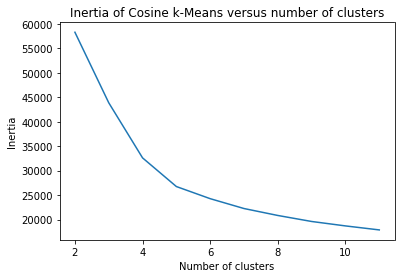

In [51]:
scores = [KMeans(n_clusters=i+2).fit(normalized_vectors).inertia_  
          for i in range(10)]
sns.lineplot(np.arange(2, 12), scores)
plt.xlabel('Number of clusters')
plt.ylabel("Inertia")
plt.title("Inertia of Cosine k-Means versus number of clusters")
plt.savefig("intertia_cosine_kmeans.jpg", dpi=300)

# Corr. plot

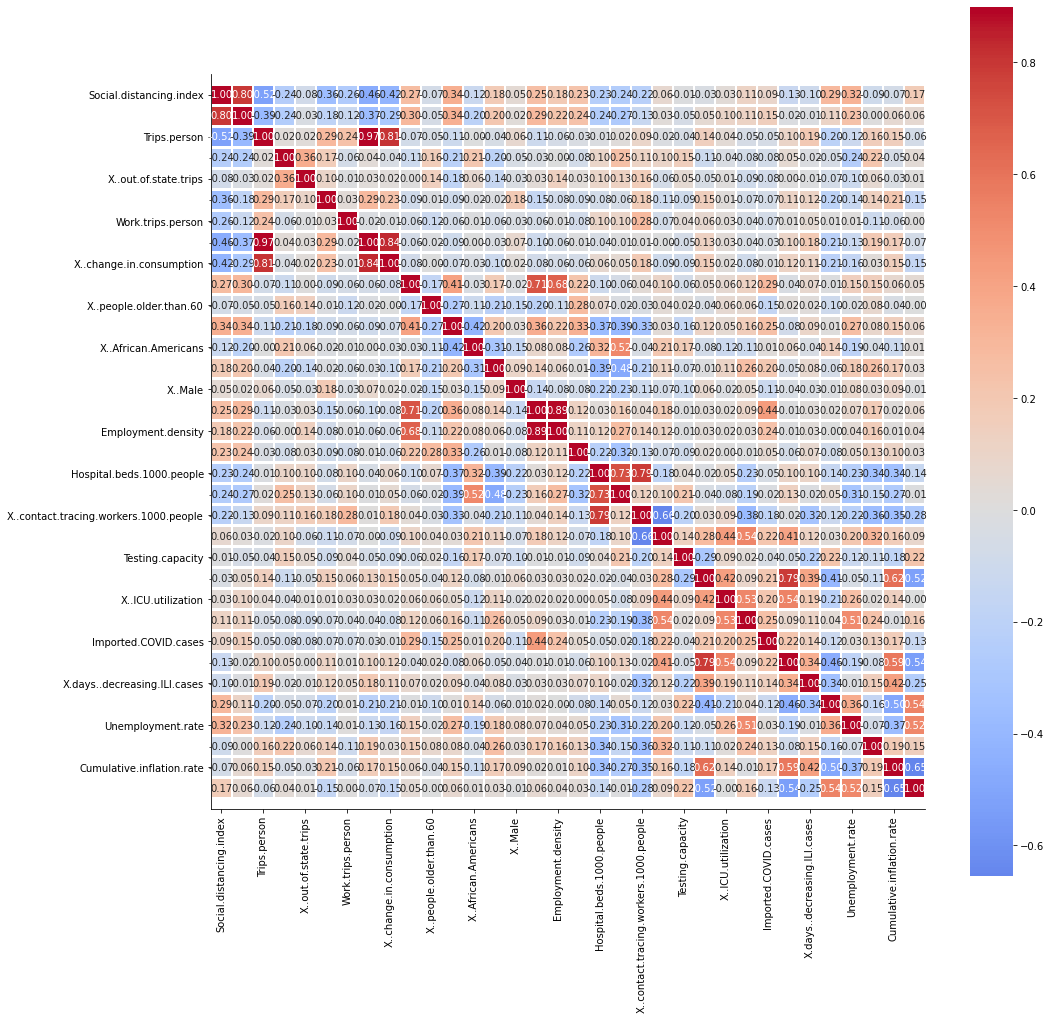

In [61]:
corr = maryland_sd_inertia_6states_filtered[X_cols].corr()
g = sns.heatmap(corr, vmax=.9, center=0,
               square=True, linewidths=1.5, cbar_kws={"shrink": .8}, annot=True, fmt='.2f', cmap='coolwarm')
bottom, top = g.get_ylim()
g.set_ylim(bottom + 0.5, top - 0.5)
sns.despine()
g.figure.set_size_inches(16, 20)

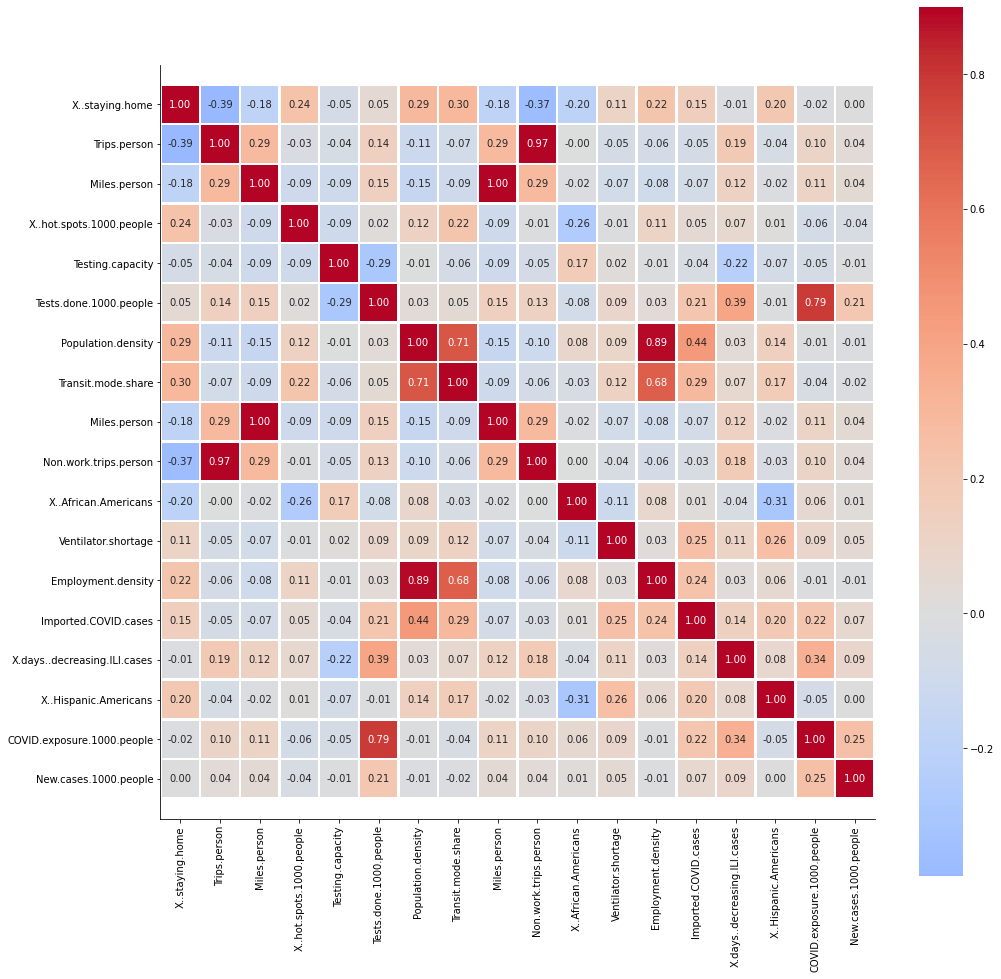

In [53]:
corr = X.corr()
g = sns.heatmap(corr, vmax=.9, center=0,
               square=True, linewidths=1.5, cbar_kws={"shrink": .8}, annot=True, fmt='.2f', cmap='coolwarm')
bottom, top = g.get_ylim()
g.set_ylim(bottom + 0.5, top - 0.5)
sns.despine()
g.figure.set_size_inches(16, 20)

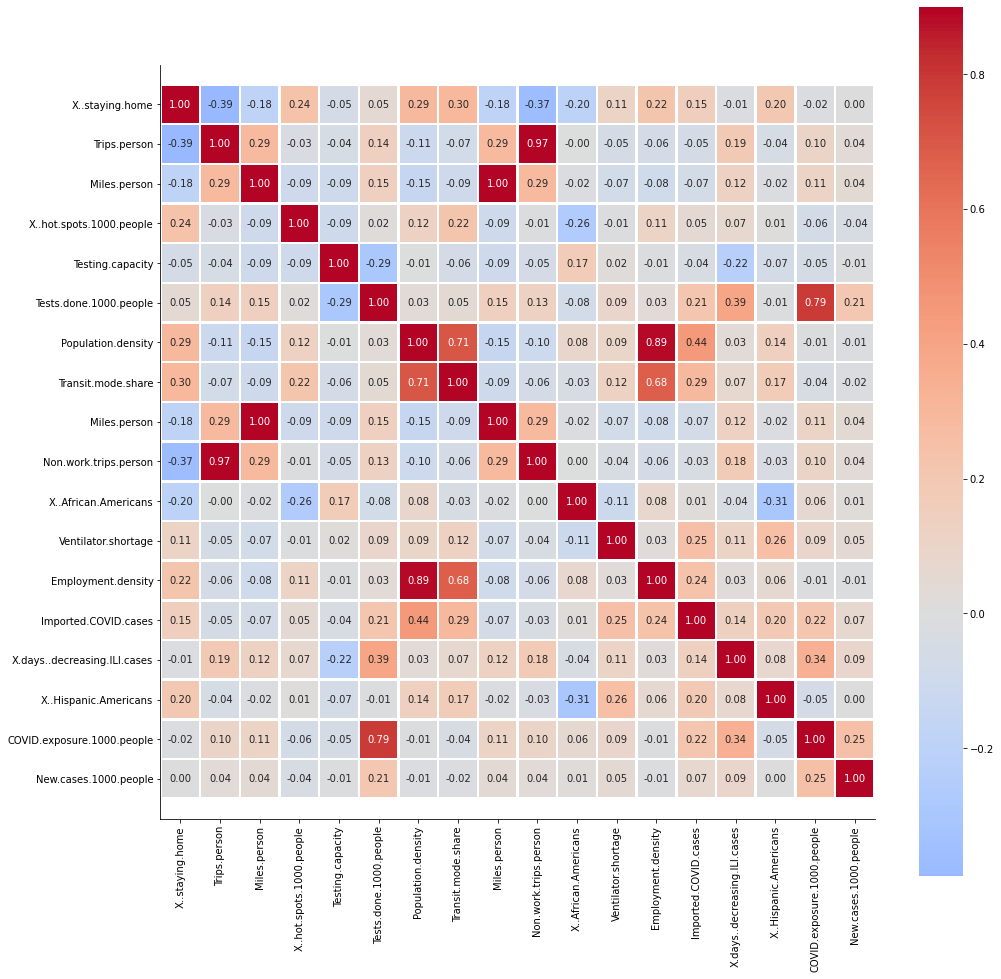

In [54]:
corr = maryland_sd_inertia_6states_filtered[min_XCols].corr()
g = sns.heatmap(corr, vmax=.9, center=0,
               square=True, linewidths=1.5, cbar_kws={"shrink": .8}, annot=True, fmt='.2f', cmap='coolwarm')
bottom, top = g.get_ylim()
g.set_ylim(bottom + 0.5, top - 0.5)
sns.despine()
g.figure.set_size_inches(16, 20)

# Pair plot


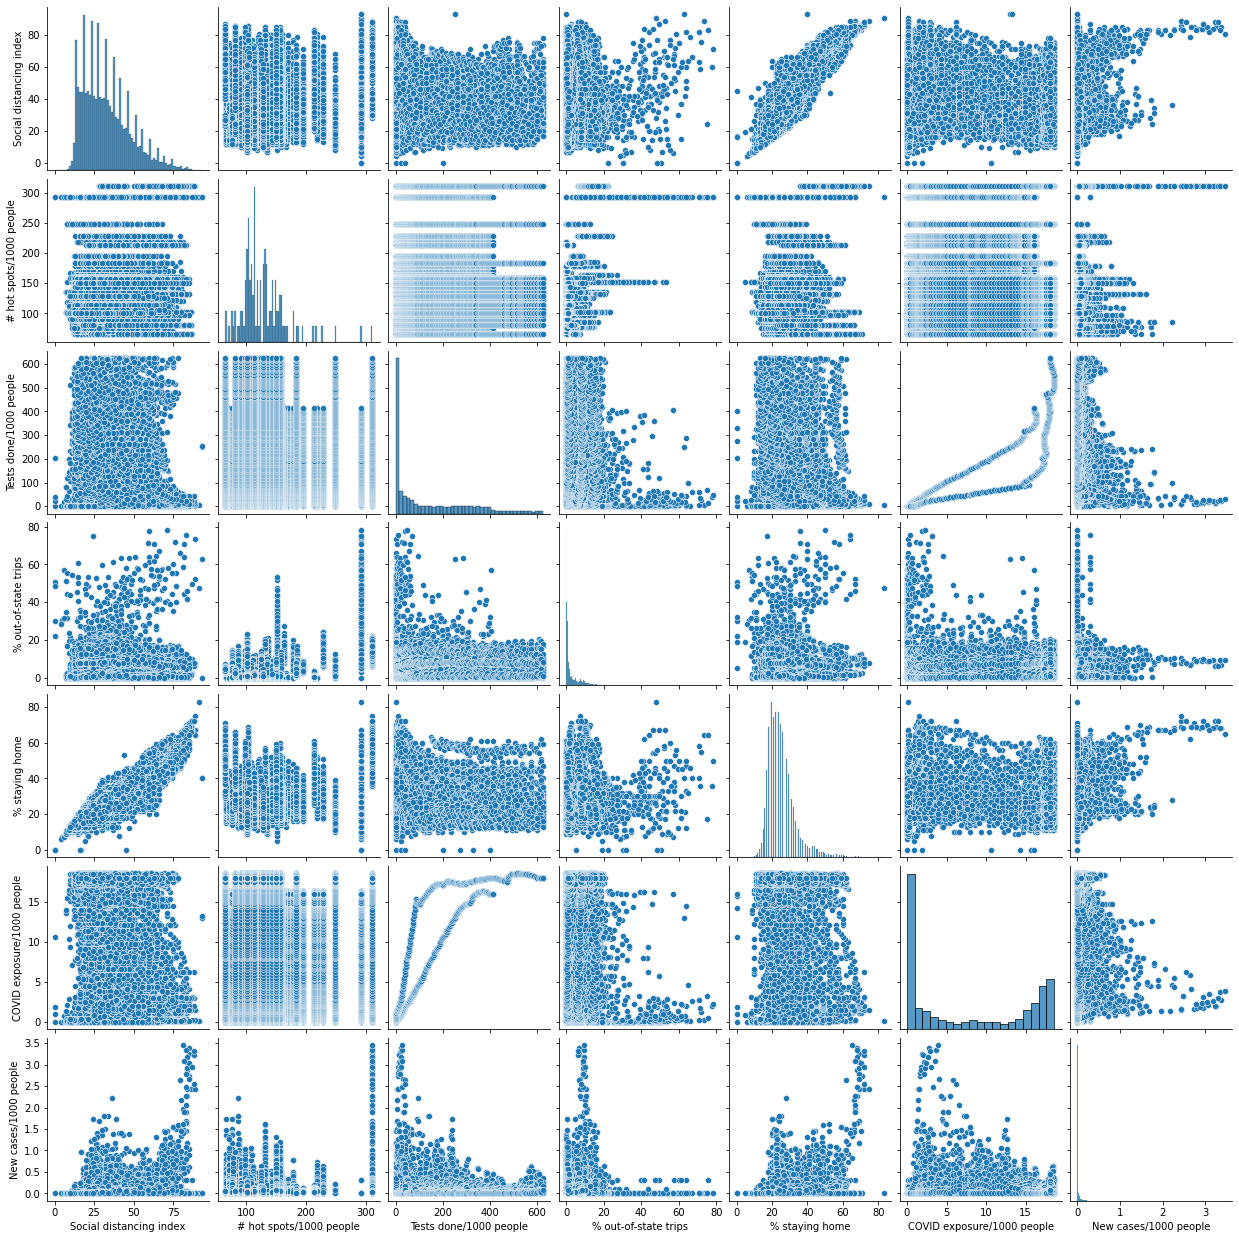

In [ ]:
# pairplot with hue day 
sns.pairplot(X) 
# to show 
plt.show()

# 2D plots between important features

In [ ]:
min_XCols

['Social distancing index',
 '# hot spots/1000 people',
 'Tests done/1000 people',
 '% out-of-state trips',
 '% staying home',
 'COVID exposure/1000 people',
 'New cases/1000 people']

In [ ]:
X1 = data[[min_XCols[0]]]
X2 = data[[min_XCols[1]]]
X3 = data[[min_XCols[2]]]
X4 = data[[min_XCols[3]]]
X5 = data[[min_XCols[4]]]
X6 = data[[min_XCols[5]]]
Y = data[['New cases/1000 people']]

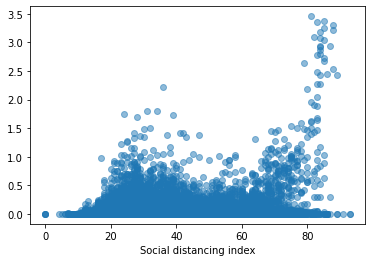

In [ ]:
plt.xlabel(min_XCols[0])
plt.scatter(X1, Y, alpha=0.5)
plt.show()

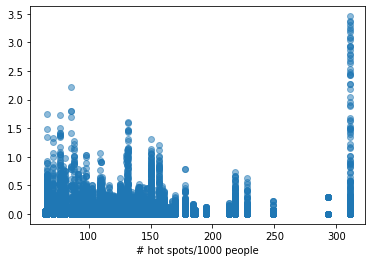

In [ ]:
plt.xlabel(min_XCols[1])

plt.scatter(X2, Y, alpha=0.5)
plt.show()

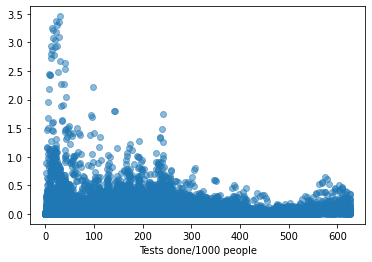

In [ ]:
plt.xlabel(min_XCols[2])

plt.scatter(X3, Y, alpha=0.5)
plt.show()

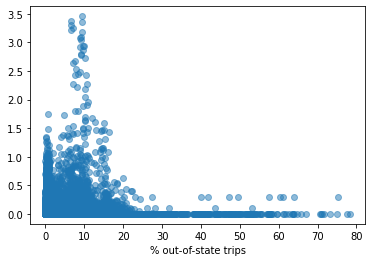

In [ ]:
plt.xlabel(min_XCols[3])

plt.scatter(X4, Y, alpha=0.5)
plt.show()

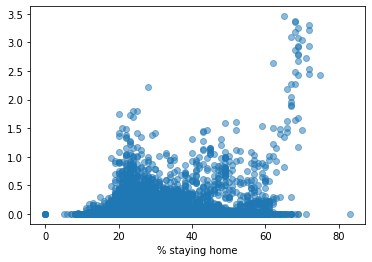

In [ ]:
plt.xlabel(min_XCols[4])

plt.scatter(X5, Y, alpha=0.5)
plt.show()

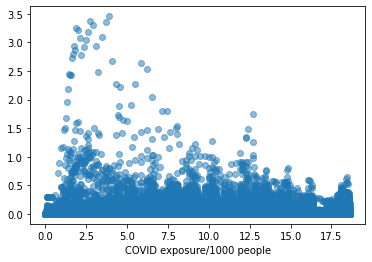

In [ ]:
plt.xlabel(min_XCols[5])

plt.scatter(X6, Y, alpha=0.5)
plt.show()

# K-means clustering

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn import preprocessing
from sklearn.metrics import silhouette_score

In [ ]:
training_inputs = maryland_sd_inertia_6states_filtered[min_XCols]
training_inputs.shape

(93020, 18)

/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning:

Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



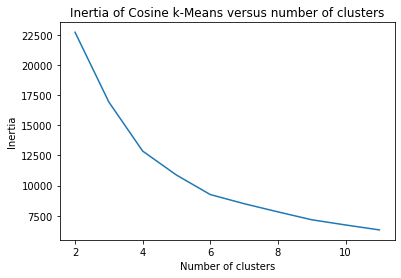

In [ ]:
training_inputs = maryland_sd_inertia_6states_filtered[min_XCols]



normalized_vectors = preprocessing.normalize(training_inputs)
scores = [KMeans(n_clusters=i+2).fit(normalized_vectors).inertia_  
          for i in range(10)]
sns.lineplot(np.arange(2, 12), scores)
plt.xlabel('Number of clusters')
plt.ylabel("Inertia")
plt.title("Inertia of Cosine k-Means versus number of clusters")
plt.savefig("intertia_cosine_kmeans.jpg", dpi=300)


In [ ]:
training_inputs.shape

(93020, 18)

In [ ]:
normalized_vectors = preprocessing.normalize(training_inputs)
normalized_kmeans = KMeans(n_clusters=4).fit(normalized_vectors)

print('Cosine kmeans:{}'.format(silhouette_score(normalized_vectors,
                                          normalized_kmeans.labels_,
                                          metric='cosine')))


Cosine kmeans:0.597839815762262


# Helper function

In [ ]:

# Data handling
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler

# Clustering
from sklearn.cluster import KMeans, DBSCAN
from sklearn import preprocessing
from sklearn.metrics import silhouette_score

# Dimensionality reduction
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

# Visualization
import seaborn as sns
import plotly.express as px
import matplotlib.pyplot as plt
import mpl_toolkits.mplot3d.axes3d as p3
from matplotlib import animation

%matplotlib inline 


def plot_corr(df):
    corr = df.corr()
    mask = np.zeros_like(corr, dtype=np.bool)
    mask[np.triu_indices_from(mask)] = True
    f, ax = plt.subplots(figsize=(11, 9))
    cmap = sns.diverging_palette(220, 10, as_cmap=True)
    sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
                square=True, linewidths=.5, cbar_kws={"shrink": .5})
    
def plot_tsne(tnse_data, kmeans_labels):
    df_tsne = pd.DataFrame(tsne_data).rename({0: 'x', 1: 'y'}, axis=1)
    df_tsne['z'] = kmeans_labels
    sns.scatterplot(x=df_tsne.x, y=df_tsne.y, hue=df_tsne.z, palette="Set2")
    plt.show()
    
def prepare_pca(n_components, data, kmeans_labels):
    names = ['x', 'y', 'z']
    matrix = PCA(n_components=n_components).fit_transform(data)
    df_matrix = pd.DataFrame(matrix)
    df_matrix.rename({i:names[i] for i in range(n_components)}, axis=1, inplace=True)
    df_matrix['labels'] = kmeans_labels
    
    return df_matrix

def prepare_tsne(n_components, data, kmeans_labels):
    names = ['x', 'y', 'z']
    matrix = TSNE(n_components=n_components).fit_transform(data)
    df_matrix = pd.DataFrame(matrix)
    df_matrix.rename({i:names[i] for i in range(n_components)}, axis=1, inplace=True)
    df_matrix['labels'] = kmeans_labels
    
    return df_matrix

def plot_3d(df, name='labels'):
    iris = px.data.iris()
    fig = px.scatter_3d(df, x='x', y='y', z='z',
                  color=name, opacity=0.5)
    

    fig.update_traces(marker=dict(size=3))
    fig.show()
    
def plot_animation(df, label_column, name):
    def update(num):
        ax.view_init(200, num)

    N=360
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    ax.scatter(tsne_3d_df['x'], tsne_3d_df['y'], tsne_3d_df['z'], c=tsne_3d_df[label_column],
               s=6, depthshade=True, cmap='Paired')
    ax.set_zlim(-15, 25)
    ax.set_xlim(-20, 20)
    plt.tight_layout()
    ani = animation.FuncAnimation(fig, update, N, blit=False, interval=50)
    ani.save('{}.gif'.format(name), writer='imagemagick')
    plt.show()

label 0   shape (14309, 3)
label 1   shape (40072, 3)
label 2   shape (19707, 3)
label 3   shape (18932, 3)


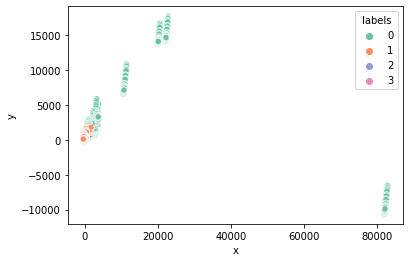

In [ ]:
pca_df = prepare_pca(2, training_inputs, normalized_kmeans.labels_)
sns.scatterplot(x=pca_df.x, y=pca_df.y, hue=pca_df.labels, 
                palette="Set2")
for label in pca_df.labels.unique():
  print("label", label, "  shape",pca_df[pca_df.labels == label].shape)

# Fractal clustering

In [58]:
def fractal_clustering(df, cluster_label = 0,n_clusters=5):
    df_filtered = df[df['cluster'] == cluster_label]
    training_inputs = df_filtered[X_cols].values

    X = training_inputs
    normalized_vectors = preprocessing.normalize(training_inputs)
    normalized_kmeans = KMeans(n_clusters=n_clusters).fit(normalized_vectors)
    print('Cosine kmeans:{}'.format(silhouette_score(normalized_vectors,
                                          normalized_kmeans.labels_,
                                          metric='cosine')))
    
    pca_df = prepare_pca(2, X, normalized_kmeans.labels_)
    sns.scatterplot(x=pca_df.x, y=pca_df.y, hue=pca_df.labels, 
                palette="Set2")
    
    df_filtered['cluster'] = pca_df.labels.to_list()
  
    return df_filtered

In [ ]:
maryland_sd_inertia_6states_filtered['cluster'] = pca_df.labels.to_list()


In [ ]:
print(maryland_sd_inertia_6states_filtered['date'].min())
maryland_sd_inertia_6states_filtered['date'].max()

2020-03-16


'2020-10-13'

In [ ]:
maryland_sd_inertia_6states_filtered.shape

(93020, 47)

# function to find maximum covid cases

In [70]:
def max_covid_cases(df, cluster= 0):
  data = df[df['cluster'] == cluster]
  return min(data['New cases/1000 people'].values),max(data['New cases/1000 people'].values)

def min_covid_cases(df, cluster= 0):
  data = df[df['cluster'] == cluster]
  return min(data['New cases/1000 people'].values)

In [ ]:
print(max_covid_cases(maryland_sd_inertia_6states_filtered, cluster=0))
print(max_covid_cases(maryland_sd_inertia_6states_filtered, cluster=1))
print(max_covid_cases(maryland_sd_inertia_6states_filtered, cluster=2))
print(max_covid_cases(maryland_sd_inertia_6states_filtered, cluster=3))
#print(max_covid_cases(maryland_sd_inertia_6states_filtered, cluster=4))




(0.0, 3.4561)
(0.0, 9.0602)
(0.0, 2.729)
(0.0, 7.8662)


Cosine kmeans:0.7681813108520691


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:16: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



(40072, 47)
label 0   shape (22300, 47)
label 3   shape (6391, 47)
label 2   shape (2794, 47)
label 1   shape (8587, 47)


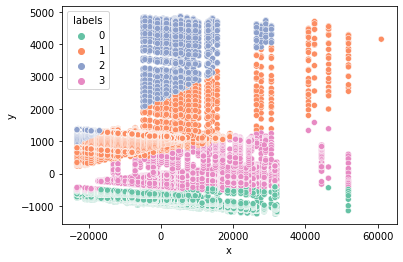

In [ ]:
df_cluster1 = fractal_clustering(maryland_sd_inertia_6states_filtered, cluster_label=1,n_clusters=4)
print(df_cluster1.shape)
for label in df_cluster1.cluster.unique():
  print("label", label, "  shape",df_cluster1[df_cluster1.cluster == label].shape)

In [ ]:
print(max_covid_cases(df_cluster1, cluster=0))
print(max_covid_cases(df_cluster1, cluster=1))
print(max_covid_cases(df_cluster1, cluster=2))
print(max_covid_cases(df_cluster1, cluster=3))
#print(max_covid_cases(df_cluster1, cluster=4))

(0.0, 5.1960000000000015)
(0.0, 9.0602)
(0.0, 1.7805)
(0.0, 4.9803)


Cosine kmeans:0.502855958443591
(8587, 47)
label 0   shape (1317, 47)
label 3   shape (3440, 47)
label 1   shape (943, 47)
label 2   shape (2887, 47)


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:16: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



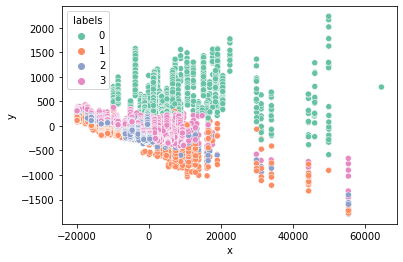

In [ ]:
df_cluster1_0 = fractal_clustering(df_cluster1, cluster_label=1,n_clusters=4)
print(df_cluster1_0.shape)
for label in df_cluster1_0.cluster.unique():
  print("label", label, "  shape",df_cluster1_0[df_cluster1_0.cluster == label].shape)

In [ ]:
print(max_covid_cases(df_cluster1_0, cluster=0))
print(max_covid_cases(df_cluster1_0, cluster=1))
print(max_covid_cases(df_cluster1_0, cluster=2))
print(max_covid_cases(df_cluster1_0, cluster=3))
#print(max_covid_cases(df_cluster1_0, cluster=4))

(0.0, 3.6116)
(0.0, 3.3)
(0.0, 5.7504)
(0.0, 9.0602)


Cosine kmeans:0.3913610488782279
(3440, 47)
label 2   shape (506, 47)
label 1   shape (692, 47)
label 0   shape (1030, 47)
label 3   shape (1212, 47)


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:16: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



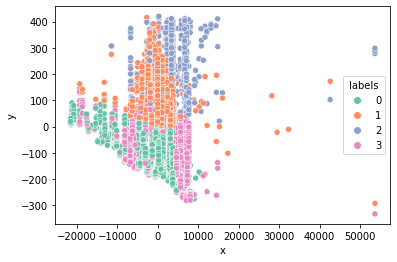

In [ ]:
df_cluster1_03 = fractal_clustering(df_cluster1_0, cluster_label=3,n_clusters=4)
print(df_cluster1_03.shape)
for label in df_cluster1_03.cluster.unique():
  print("label", label, "  shape",df_cluster1_03[df_cluster1_03.cluster == label].shape)

In [ ]:
print(max_covid_cases(df_cluster1_03, cluster=0))
print(max_covid_cases(df_cluster1_03, cluster=1))
print(max_covid_cases(df_cluster1_03, cluster=2))
print(max_covid_cases(df_cluster1_03, cluster=3))
#print(max_covid_cases(df_cluster1_1, cluster=4))

(0.0, 2.9113)
(0.0, 3.3976)
(0.0, 1.5672)
(0.0, 9.0602)


Cosine kmeans:0.3716248842916325
(1212, 47)
label 2   shape (286, 47)
label 0   shape (356, 47)
label 1   shape (301, 47)
label 4   shape (141, 47)
label 3   shape (128, 47)


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:16: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



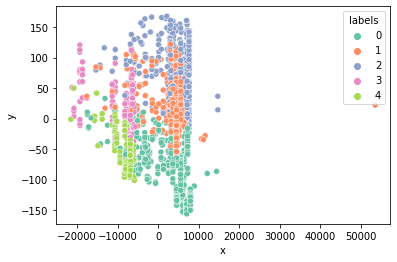

In [ ]:
df_cluster1_033 = fractal_clustering(df_cluster1_03, cluster_label=3,n_clusters=5)
print(df_cluster1_033.shape)
for label in df_cluster1_033.cluster.unique():
  print("label", label, "  shape",df_cluster1_033[df_cluster1_033.cluster == label].shape)

In [ ]:
print(max_covid_cases(df_cluster1_033, cluster=0))
print(max_covid_cases(df_cluster1_033, cluster=1))
print(max_covid_cases(df_cluster1_033, cluster=2))
print(max_covid_cases(df_cluster1_033, cluster=3))


(0.0, 2.4637)
(0.0, 5.4526)
(0.0, 9.0602)
(0.0, 1.9079)


Cosine kmeans:0.41454431019842436
(286, 47)
label 2   shape (23, 47)
label 4   shape (3, 47)
label 0   shape (84, 47)
label 1   shape (108, 47)
label 3   shape (68, 47)


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:16: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



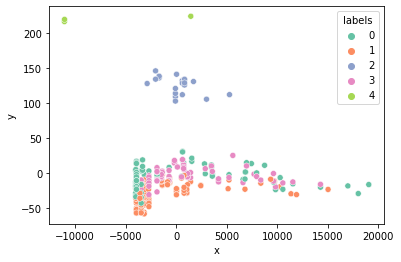

In [ ]:
df_cluster1_0332 = fractal_clustering(df_cluster1_033, cluster_label=2,n_clusters=5)
print(df_cluster1_0332.shape)
for label in df_cluster1_0332.cluster.unique():
  print("label", label, "  shape",df_cluster1_0332[df_cluster1_0332.cluster == label].shape)

In [ ]:
print(max_covid_cases(df_cluster1_0332, cluster=0))
print(max_covid_cases(df_cluster1_0332, cluster=1))
print(max_covid_cases(df_cluster1_0332, cluster=2))
print(max_covid_cases(df_cluster1_0332, cluster=3))
#print(max_covid_cases(df_cluster1_1_4_2, cluster=4))

(0.0, 9.0371)
(0.0, 1.5687)
(0.0, 0.075)
(0.0, 9.0602)


Cosine kmeans:0.2761141899954825
(84, 47)
label 1   shape (29, 47)
label 3   shape (28, 47)
label 0   shape (26, 47)
label 2   shape (1, 47)
(0.0, 9.0371)
(0.0, 0.7231)
(0.0315, 0.0315)
(0.0, 0.3024)


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:16: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



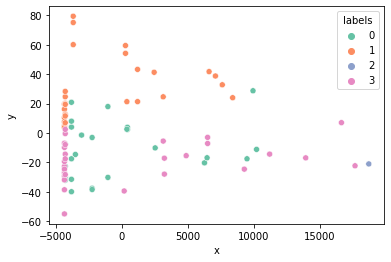

In [ ]:
df_cluster1_03320 = fractal_clustering(df_cluster1_0332, cluster_label=0,n_clusters=4)
print(df_cluster1_03320.shape)
for label in df_cluster1_03320.cluster.unique():
  print("label", label, "  shape",df_cluster1_03320[df_cluster1_03320.cluster == label].shape)

print(max_covid_cases(df_cluster1_03320, cluster=0))
print(max_covid_cases(df_cluster1_03320, cluster=1))
print(max_covid_cases(df_cluster1_03320, cluster=2))
print(max_covid_cases(df_cluster1_03320, cluster=3))
#print(max_covid_cases(df_cluster1_1_4_2_0, cluster=4))

In [ ]:
df_cluster1_03320[(df_cluster1_03320['cluster'] == 0) ][min_XCols]

,% staying home,Trips/person,Miles/person,# hot spots/1000 people,Testing capacity,Tests done/1000 people,Population density,Transit mode share,Miles/person,Non-work trips/person,% African Americans,Ventilator shortage,Employment density,Imported COVID cases,#days: decreasing ILI cases,% Hispanic Americans,COVID exposure/1000 people,New cases/1000 people
121900,13,3.96,56.2,113,11.9,139.38,26,0.32,56.2,3.37,12.5,2197,5,268,140,20.5,14.09,0.1450
121901,17,3.55,44.5,113,12.0,139.80,26,0.32,44.5,3.25,12.5,2210,5,273,140,20.5,14.27,0.0906
121907,13,4.17,46.2,113,12.2,149.19,26,0.32,46.2,3.57,12.5,2244,5,253,147,20.5,15.46,0.0181
121908,15,3.94,52.7,113,12.2,150.57,26,0.32,52.7,3.64,12.5,2243,5,285,147,20.5,15.66,0.0181
121956,24,3.82,31.6,115,11.9,139.38,21,0.48,31.6,3.37,2.4,2197,24,266,140,48.4,14.09,0.5566
123627,23,3.31,49.0,86,11.3,108.15,17,0.00,49.0,2.86,3.9,1669,4,193,126,78.8,10.56,0.1009
123700,18,3.68,52.8,114,11.5,130.58,19,0.93,52.8,3.33,6.6,2078,6,245,133,50.5,12.71,0.1761
123701,23,3.29,47.8,114,11.5,130.58,19,0.93,47.8,2.95,6.6,2104,6,298,133,50.5,12.83,0.0640
124298,17,3.84,49.6,102,11.4,125.76,41,0.39,49.6,3.40,5.5,2019,13,260,133,42.0,12.27,0.2103
124299,17,4.07,57.0,102,11.5,127.86,41,0.39,57.0,3.72,5.5,2050,13,255,133,42.0,12.53,0.1829


Cosine kmeans:0.19393171391934347
(1174, 47)
label 2   shape (343, 47)
label 3   shape (148, 47)
label 1   shape (333, 47)
label 0   shape (226, 47)
label 4   shape (124, 47)
(0.0, 0.32299999999999995)
(0.0, 7.8662)
(0.0, 1.1558)
(0.0, 1.7768)
(0.0, 1.077)


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:16: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



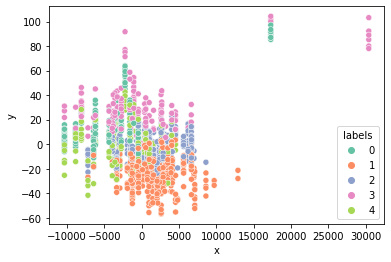

In [ ]:
df_cluster1_1_4_2_0 = fractal_clustering(df_cluster1_1_4_2, cluster_label=0,n_clusters=5)
print(df_cluster1_1_4_2_0.shape)
for label in df_cluster1_1_4_2_0.cluster.unique():
  print("label", label, "  shape",df_cluster1_1_4_2_0[df_cluster1_1_4_2_0.cluster == label].shape)

print(max_covid_cases(df_cluster1_1_4_2_0, cluster=0))
print(max_covid_cases(df_cluster1_1_4_2_0, cluster=1))
print(max_covid_cases(df_cluster1_1_4_2_0, cluster=2))
print(max_covid_cases(df_cluster1_1_4_2_0, cluster=3))
print(max_covid_cases(df_cluster1_1_4_2_0, cluster=4))

Cosine kmeans:0.27716504308676


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:16: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



(333, 47)
label 2   shape (65, 47)
label 3   shape (81, 47)
label 1   shape (106, 47)
label 0   shape (77, 47)
label 4   shape (4, 47)
(0.0, 0.5455)
(0.0, 7.8662)
(0.0, 0.6829999999999999)
(0.0, 1.6023)
(0.0, 0.1104)


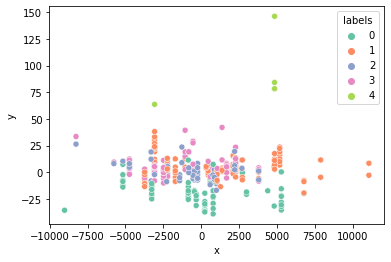

In [ ]:
df_cluster1_1_4_2_01 = fractal_clustering(df_cluster1_1_4_2_0, cluster_label=1,n_clusters=5)
print(df_cluster1_1_4_2_01.shape)
for label in df_cluster1_1_4_2_01.cluster.unique():
  print("label", label, "  shape",df_cluster1_1_4_2_01[df_cluster1_1_4_2_01.cluster == label].shape)

print(max_covid_cases(df_cluster1_1_4_2_01, cluster=0))
print(max_covid_cases(df_cluster1_1_4_2_01, cluster=1))
print(max_covid_cases(df_cluster1_1_4_2_01, cluster=2))
print(max_covid_cases(df_cluster1_1_4_2_01, cluster=3))
print(max_covid_cases(df_cluster1_1_4_2_01, cluster=4))

Cosine kmeans:0.24000640184905275
(106, 47)
label 0   shape (26, 47)
label 1   shape (26, 47)
label 3   shape (19, 47)
label 4   shape (9, 47)
label 2   shape (26, 47)
(0.0, 0.272)
(0.0, 0.1848)
(0.0, 0.3184)
(0.0, 7.8662)
(0.0, 0.3537)


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:16: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



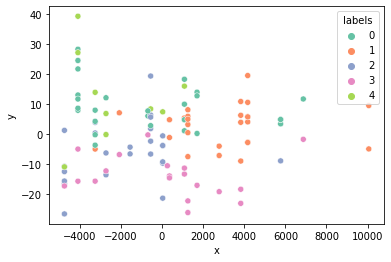

In [ ]:
df_cluster1_1_4_2_011 = fractal_clustering(df_cluster1_1_4_2_01, cluster_label=1,n_clusters=5)
print(df_cluster1_1_4_2_011.shape)
for label in df_cluster1_1_4_2_011.cluster.unique():
  print("label", label, "  shape",df_cluster1_1_4_2_011[df_cluster1_1_4_2_011.cluster == label].shape)

print(max_covid_cases(df_cluster1_1_4_2_011, cluster=0))
print(max_covid_cases(df_cluster1_1_4_2_011, cluster=1))
print(max_covid_cases(df_cluster1_1_4_2_011, cluster=2))
print(max_covid_cases(df_cluster1_1_4_2_011, cluster=3))
print(max_covid_cases(df_cluster1_1_4_2_011, cluster=4))

In [ ]:
min_XCols1 = ['State','CTNAME','Social distancing index','# hot spots/1000 people','Testing capacity','Tests done/1000 people',
              '% out-of-state trips','Median income','Population density','Transit mode share',
             '% African Americans', 'Ventilator shortage','Employment density',
       'Imported COVID cases','#days: decreasing ILI cases','% Hispanic Americans','% staying home','COVID exposure/1000 people',
             'New cases/1000 people']
             
df_cluster1_1_4_2_011[df_cluster1_1_4_2_011['cluster'] == 3][min_XCols1]

,State,CTNAME,Social distancing index,# hot spots/1000 people,Testing capacity,Tests done/1000 people,% out-of-state trips,Median income,Population density,Transit mode share,% African Americans,Ventilator shortage,Employment density,Imported COVID cases,#days: decreasing ILI cases,% Hispanic Americans,% staying home,COVID exposure/1000 people,New cases/1000 people
29078,Iowa,Cherokee County,17,162,13.0,45.29,1.1,54658,20,0.00,2.3,145,9,30,112,1.3,16,4.65,0.2356
30482,Iowa,Guthrie County,21,175,12.4,50.40,1.9,57075,18,0.25,0.0,157,5,37,112,2.7,17,4.99,0.0311
30655,Iowa,Hancock County,16,157,12.2,52.10,1.4,61167,19,0.53,0.6,160,10,46,119,4.2,18,5.21,0.0000
31068,Iowa,Humboldt County,12,156,13.2,44.21,1.1,52219,22,0.04,0.3,140,8,32,112,4.3,16,4.66,0.0349
31547,Iowa,Keokuk County,28,144,13.2,42.05,0.8,51043,18,0.32,0.4,132,4,29,105,1.6,15,4.64,0.0326
31827,Iowa,Lucas County,20,127,13.5,40.48,1.6,50206,20,0.00,0.2,129,6,28,105,1.8,10,4.44,0.1157
31828,Iowa,Lucas County,33,127,13.2,42.05,2.5,50206,20,0.00,0.2,132,6,23,105,1.8,22,4.64,0.0771
32792,Iowa,Osceola County,27,162,12.5,49.52,15.3,58125,15,0.22,1.3,155,6,19,112,7.8,22,4.91,0.0552
32794,Iowa,Osceola County,24,162,12.2,51.86,14.9,58125,15,0.22,1.3,159,6,21,119,7.8,24,5.10,0.0552
79315,Iowa,Buena Vista County,19,140,12.8,46.68,1.2,54556,35,0.28,2.7,148,23,46,112,25.2,18,4.72,7.8662


# GMM Clustering

In [62]:
training_inputs = maryland_sd_inertia_6states_filtered[min_XCols]

In [63]:
from sklearn.mixture import GaussianMixture
gmm = GaussianMixture(n_components=7)
gmm.fit(training_inputs)

GaussianMixture(covariance_type='full', init_params='kmeans', max_iter=100,
                means_init=None, n_components=7, n_init=1, precisions_init=None,
                random_state=None, reg_covar=1e-06, tol=0.001, verbose=0,
                verbose_interval=10, warm_start=False, weights_init=None)

In [64]:
training_inputs.shape

(177585, 18)

In [65]:
labels = gmm.predict(training_inputs)
frame = maryland_sd_inertia_6states_filtered.copy() #pd.DataFrame(training_inputs)
frame['cluster'] = labels

In [66]:
len(min_XCols)

18

In [67]:
min_XCols

['X..staying.home',
 'Trips.person',
 'Miles.person',
 'X..hot.spots.1000.people',
 'Testing.capacity',
 'Tests.done.1000.people',
 'Population.density',
 'Transit.mode.share',
 'Miles.person',
 'Non.work.trips.person',
 'X..African.Americans',
 'Ventilator.shortage',
 'Employment.density',
 'Imported.COVID.cases',
 'X.days..decreasing.ILI.cases',
 'X..Hispanic.Americans',
 'COVID.exposure.1000.people',
 'New.cases.1000.people']

In [68]:
min_XCols = ['% staying home', 'Trips/person','Miles/person','# hot spots/1000 people','Testing capacity','Tests done/1000 people',
             'Population density','Transit mode share','Miles/person', 'Non-work trips/person',
             '% African Americans', 'Ventilator shortage','Employment density',
       'Imported COVID cases','#days: decreasing ILI cases','% Hispanic Americans','COVID exposure/1000 people',
             'New cases/1000 people']

min_XCols = ['X..staying.home','Trips.person','Miles.person','X..hot.spots.1000.people','Testing.capacity',
 'Tests.done.1000.people','Population.density','Transit.mode.share','Miles.person','Non.work.trips.person','X..African.Americans',
 'Ventilator.shortage','Employment.density','Imported.COVID.cases','X.days..decreasing.ILI.cases',
 'X..Hispanic.Americans','COVID.exposure.1000.people','New.cases.1000.people']

## Defining `max_covid_cases`

In [72]:
def max_covid_cases(df, cluster= 0):
  data = df[df['cluster'] == cluster]
  return min(data['New.cases.1000.people'].values),max(data['New.cases.1000.people'].values)


0 (20587, 44)
(0.0, 126.3835)
1 (16495, 44)
(0.0, 15.767000000000001)
2 (275, 44)
(0.0085, 0.4888)
3 (42505, 44)
(0.0, 0.3673)
4 (1100, 44)
(0.0004, 1.2403)
5 (35181, 44)
(0.0, 2.1807)


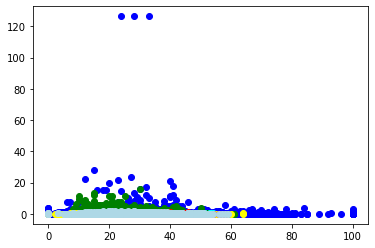

In [73]:
color=['blue','green','cyan', 'yellow','red','lightblue','magenta']
for k in range(0,6):
    data = frame[frame["cluster"]==k]
    print(k, data.shape)
    print(max_covid_cases(data,k))
    #print(min_XCols[2],data[['% staying home']].shape)
    #print(min_XCols[17],data[['New cases/1000 people']].shape)

    plt.scatter(data[min_XCols[0]],data[min_XCols[17]],c=color[k])
plt.show()

# First filter

In [74]:
df2  = frame[frame["cluster"]==5][min_XCols]
df2.shape

(35181, 18)

18
Index(['X..staying.home', 'Trips.person', 'Miles.person',
       'X..hot.spots.1000.people', 'Testing.capacity',
       'Tests.done.1000.people', 'Population.density', 'Transit.mode.share',
       'Miles.person', 'Non.work.trips.person', 'X..African.Americans',
       'Ventilator.shortage', 'Employment.density', 'Imported.COVID.cases',
       'X.days..decreasing.ILI.cases', 'X..Hispanic.Americans',
       'COVID.exposure.1000.people', 'New.cases.1000.people'],
      dtype='object')
     X..staying.home  ...  New.cases.1000.people
204               18  ...                 0.2338
205               17  ...                 0.2758
206               23  ...                 0.2218
207               26  ...                 0.1918
209               18  ...                 0.2458

[5 rows x 18 columns]
(35181, 18)
[0 0 0 ... 3 3 5]
frame1:  (35181, 19)
0 (7705, 19)
(0.0105, 1.2344)
1 (5579, 19)
(0.0, 0.4895)
2 (376, 19)
(0.0706, 1.3581)
3 (5357, 19)
(0.0, 2.1807)
4 (6496, 19)
(0.0, 1.1998)
5 

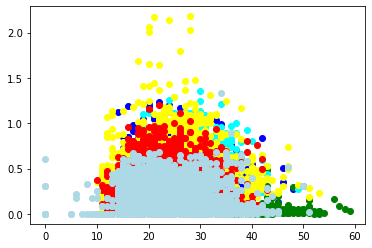

In [75]:
data1 = df2.copy()
print(len(min_XCols))
print(data1.columns)
print(data1.head())
print(data1.shape)

training_inputs1 = data1
gmm = GaussianMixture(n_components=7)
gmm.fit(training_inputs1)
labels = gmm.predict(training_inputs1)
print(labels)
frame1 = data1.copy()#pd.DataFrame(training_inputs1)
frame1['cluster'] = labels
print('frame1: ',frame1.shape)

color=['blue','green','cyan', 'yellow','red','lightblue','magenta']
for k in range(0,6):
    data = frame1[frame1["cluster"]==k]
    print(k, data.shape)
    print(max_covid_cases(data,k))
    #print(min_XCols[2],data[['% staying home']].shape)
    #print(min_XCols[17],data[['New cases/1000 people']].shape)

    plt.scatter(data[min_XCols[0]],data[min_XCols[17]],c=color[k])
plt.show()

In [76]:
df = frame1[(frame1['cluster'] == 2) | (frame1['cluster'] == 5)]
print(df.shape)
df = df.drop(columns=['cluster'])
print(df.shape)

(7110, 19)
(7110, 18)


Index(['X..staying.home', 'Trips.person', 'Miles.person',
       'X..hot.spots.1000.people', 'Testing.capacity',
       'Tests.done.1000.people', 'Population.density', 'Transit.mode.share',
       'Miles.person', 'Non.work.trips.person', 'X..African.Americans',
       'Ventilator.shortage', 'Employment.density', 'Imported.COVID.cases',
       'X.days..decreasing.ILI.cases', 'X..Hispanic.Americans',
       'COVID.exposure.1000.people', 'New.cases.1000.people'],
      dtype='object')
18
Index(['X..staying.home', 'Trips.person', 'Miles.person',
       'X..hot.spots.1000.people', 'Testing.capacity',
       'Tests.done.1000.people', 'Population.density', 'Transit.mode.share',
       'Miles.person', 'Non.work.trips.person', 'X..African.Americans',
       'Ventilator.shortage', 'Employment.density', 'Imported.COVID.cases',
       'X.days..decreasing.ILI.cases', 'X..Hispanic.Americans',
       'COVID.exposure.1000.people', 'New.cases.1000.people'],
      dtype='object')
       X..staying.home 

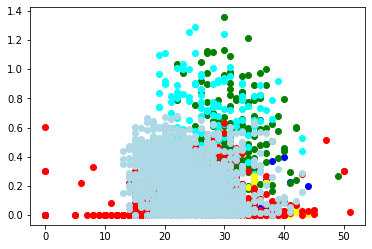

In [77]:

print(data1.columns)
data2 = df.copy()
print(len(min_XCols))
print(data2.columns)
print(data2.head())
print(data2.shape)

training_inputs2 = data2.copy()
gmm = GaussianMixture(n_components=7)
gmm.fit(training_inputs2)
labels = gmm.predict(training_inputs2)
frame1 = data2.copy()#pd.DataFrame(training_inputs2)
frame1['cluster'] = labels

color=['blue','green','cyan', 'yellow','red','lightblue','magenta']
for k in range(0,6):
    data = frame1[frame1["cluster"]==k]
    print(k, data.shape)
    print(max_covid_cases(data,k))
    #print(min_XCols[2],data[['% staying home']].shape)
    #print(min_XCols[17],data[['New cases/1000 people']].shape)

    plt.scatter(data[min_XCols[0]],data[min_XCols[17]],c=color[k])
plt.show()

In [78]:
df = frame1[(frame1['cluster'] == 3) | (frame1['cluster'] == 4) ]
print(df.shape)
df = df.drop(columns=['cluster'])
print(df.shape)

(2448, 19)
(2448, 18)


18
Index(['X..staying.home', 'Trips.person', 'Miles.person',
       'X..hot.spots.1000.people', 'Testing.capacity',
       'Tests.done.1000.people', 'Population.density', 'Transit.mode.share',
       'Miles.person', 'Non.work.trips.person', 'X..African.Americans',
       'Ventilator.shortage', 'Employment.density', 'Imported.COVID.cases',
       'X.days..decreasing.ILI.cases', 'X..Hispanic.Americans',
       'COVID.exposure.1000.people', 'New.cases.1000.people'],
      dtype='object')
       X..staying.home  ...  New.cases.1000.people
24275               25  ...                 0.0057
24276               24  ...                 0.0034
24278               21  ...                 0.0046
24279               24  ...                 0.0046
24281               26  ...                 0.0000

[5 rows x 18 columns]
(2448, 18)
0 (159, 19)
(0.0, 0.466)
1 (313, 19)
(0.0, 0.5086)
2 (152, 19)
(0.0, 0.6055)
3 (356, 19)
(0.0057, 0.2063)
4 (268, 19)
(0.0, 0.6316)
5 (461, 19)
(0.0, 0.3857)


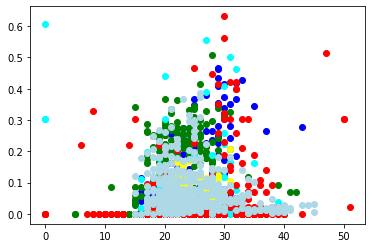

In [79]:
data2 = df.copy()
print(len(min_XCols))
print(data2.columns)
print(data2.head())
print(data2.shape)

training_inputs2 = data2
gmm = GaussianMixture(n_components=7)
gmm.fit(training_inputs2)
labels = gmm.predict(training_inputs2)
frame1 = (training_inputs2)
frame1['cluster'] = labels

color=['blue','green','cyan', 'yellow','red','lightblue','magenta']
for k in range(0,6):
    data = frame1[frame1["cluster"]==k]
    print(k, data.shape)
    print(max_covid_cases(data,k))
    #print(min_XCols[2],data[['% staying home']].shape)
    #print(min_XCols[17],data[['New cases/1000 people']].shape)

    plt.scatter(data[min_XCols[0]],data[min_XCols[17]],c=color[k])
plt.show()

In [ ]:
df = frame1[(frame1['cluster'] == 1) |(frame1['cluster'] == 4) |(frame1['cluster'] == 3)|(frame1['cluster'] == 2) ]
print(df.shape)
df = df.drop(columns=['cluster'])
print(df.shape)

(650, 19)
(650, 18)


18
Index(['% staying home', 'Trips/person', 'Miles/person',
       '# hot spots/1000 people', 'Testing capacity', 'Tests done/1000 people',
       'Population density', 'Transit mode share', 'Miles/person',
       'Non-work trips/person', '% African Americans', 'Ventilator shortage',
       'Employment density', 'Imported COVID cases',
       '#days: decreasing ILI cases', '% Hispanic Americans',
       'COVID exposure/1000 people', 'New cases/1000 people'],
      dtype='object')
       % staying home  ...  New cases/1000 people
28571              16  ...                 7.5643
28572              16  ...                 7.6985
28573              17  ...                 3.1364
28574              15  ...                 3.6061
28575              19  ...                 3.2538

[5 rows x 18 columns]
(650, 18)
0 (102, 19)
(0.0, 5.2712)
1 (145, 19)
(0.0, 7.8662)
2 (65, 19)
(0.0, 1.1999)
3 (165, 19)
(0.0, 5.7504)
4 (119, 19)
(0.0, 2.1948)
5 (26, 19)
(0.0, 1.1397)


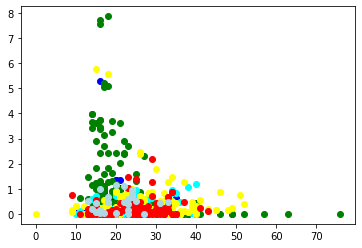

In [ ]:
data2 = df.copy()
print(len(min_XCols))
print(data2.columns)
print(data2.head())
print(data2.shape)

training_inputs2 = data2
gmm = GaussianMixture(n_components=7)
gmm.fit(training_inputs2)
labels = gmm.predict(training_inputs2)
frame1 = (training_inputs2)
frame1['cluster'] = labels

color=['blue','green','cyan', 'yellow','red','lightblue','magenta']
for k in range(0,6):
    data = frame1[frame1["cluster"]==k]
    print(k, data.shape)
    print(max_covid_cases(data,k))
    #print(min_XCols[2],data[['% staying home']].shape)
    #print(min_XCols[17],data[['New cases/1000 people']].shape)

    plt.scatter(data[min_XCols[0]],data[min_XCols[17]],c=color[k])
plt.show()

In [ ]:
frame1.columns

Index(['% staying home', 'Trips/person', 'Miles/person',
       '# hot spots/1000 people', 'Testing capacity', 'Tests done/1000 people',
       'Population density', 'Transit mode share', 'Miles/person',
       'Non-work trips/person', '% African Americans', 'Ventilator shortage',
       'Employment density', 'Imported COVID cases',
       '#days: decreasing ILI cases', '% Hispanic Americans',
       'COVID exposure/1000 people', 'New cases/1000 people', 'cluster'],
      dtype='object')

In [ ]:
df = frame1[(frame1['cluster'] == 0)|(frame1['cluster'] == 1)|(frame1['cluster'] == 3)]
print(df.shape)
print(df.columns)
df = df.drop(columns=['cluster'])
print(df.shape)

(412, 19)
Index(['% staying home', 'Trips/person', 'Miles/person',
       '# hot spots/1000 people', 'Testing capacity', 'Tests done/1000 people',
       'Population density', 'Transit mode share', 'Miles/person',
       'Non-work trips/person', '% African Americans', 'Ventilator shortage',
       'Employment density', 'Imported COVID cases',
       '#days: decreasing ILI cases', '% Hispanic Americans',
       'COVID exposure/1000 people', 'New cases/1000 people', 'cluster'],
      dtype='object')
(412, 18)


18
Index(['% staying home', 'Trips/person', 'Miles/person',
       '# hot spots/1000 people', 'Testing capacity', 'Tests done/1000 people',
       'Population density', 'Transit mode share', 'Miles/person',
       'Non-work trips/person', '% African Americans', 'Ventilator shortage',
       'Employment density', 'Imported COVID cases',
       '#days: decreasing ILI cases', '% Hispanic Americans',
       'COVID exposure/1000 people', 'New cases/1000 people'],
      dtype='object')
       % staying home  ...  New cases/1000 people
28571              16  ...                 7.5643
28572              16  ...                 7.6985
28573              17  ...                 3.1364
28574              15  ...                 3.6061
28575              19  ...                 3.2538

[5 rows x 18 columns]
(412, 18)
0 (64, 19)
(0.0, 1.0097)
1 (123, 19)
(0.0, 5.1960000000000015)
2 (32, 19)
(0.0, 1.3430000000000002)
3 (51, 19)
(0.0, 1.2871)
4 (22, 19)
(0.0, 7.8662)
5 (70, 19)
(0.0, 5.2712)


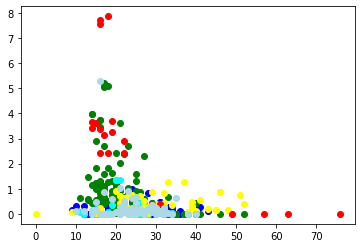

In [ ]:
data2 = df.copy()
print(len(min_XCols))
print(data2.columns)
print(data2.head())
print(data2.shape)

training_inputs2 = data2
gmm = GaussianMixture(n_components=7)
gmm.fit(training_inputs2)
labels = gmm.predict(training_inputs2)
frame1 = (training_inputs2)
frame1['cluster'] = labels

color=['blue','green','cyan', 'yellow','red','lightblue','magenta']
for k in range(0,6):
    data = frame1[frame1["cluster"]==k]
    print(k, data.shape)
    print(max_covid_cases(data,k))
    #print(min_XCols[2],data[['% staying home']].shape)
    #print(min_XCols[17],data[['New cases/1000 people']].shape)

    plt.scatter(data[min_XCols[0]],data[min_XCols[17]],c=color[k])
plt.show()

In [ ]:
df = frame1[(frame1['cluster'] == 4)]

18
Index(['% staying home', 'Trips/person', 'Miles/person',
       '# hot spots/1000 people', 'Testing capacity', 'Tests done/1000 people',
       'Population density', 'Transit mode share', 'Miles/person',
       'Non-work trips/person', '% African Americans', 'Ventilator shortage',
       'Employment density', 'Imported COVID cases',
       '#days: decreasing ILI cases', '% Hispanic Americans',
       'COVID exposure/1000 people', 'New cases/1000 people', 'cluster'],
      dtype='object')
       % staying home  Trips/person  ...  New cases/1000 people  cluster
28571              16          3.66  ...                 7.5643        4
28572              16          3.63  ...                 7.6985        4
28573              17          3.72  ...                 3.1364        4
28574              15          3.90  ...                 3.6061        4
28575              19          3.47  ...                 3.2538        4

[5 rows x 19 columns]
(22, 19)
0 (2, 19)
(0.0, 0.0)
1 (7, 19)
(2.

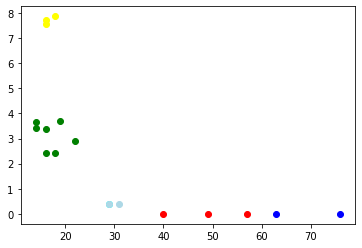

In [ ]:
data2 = df.copy()
print(len(min_XCols))
print(data2.columns)
print(data2.head())
print(data2.shape)

training_inputs2 = data2
gmm = GaussianMixture(n_components=7)
gmm.fit(training_inputs2)
labels = gmm.predict(training_inputs2)
frame1 = (training_inputs2)
frame1['cluster'] = labels

color=['blue','green','cyan', 'yellow','red','lightblue','magenta']
for k in range(0,6):
    data = frame1[frame1["cluster"]==k]
    print(k, data.shape)
    print(max_covid_cases(data,k))
    #print(min_XCols[2],data[['% staying home']].shape)
    #print(min_XCols[17],data[['New cases/1000 people']].shape)

    plt.scatter(data[min_XCols[0]],data[min_XCols[17]],c=color[k])
plt.show()

# GMM Result

In [ ]:
gmm_df = frame1[(frame1['cluster'] == 1)| (frame1['cluster'] == 3)]

In [ ]:
gmm_df.columns

Index(['% staying home', 'Trips/person', 'Miles/person',
       '# hot spots/1000 people', 'Testing capacity', 'Tests done/1000 people',
       'Population density', 'Transit mode share', 'Miles/person',
       'Non-work trips/person', '% African Americans', 'Ventilator shortage',
       'Employment density', 'Imported COVID cases',
       '#days: decreasing ILI cases', '% Hispanic Americans',
       'COVID exposure/1000 people', 'New cases/1000 people', 'cluster'],
      dtype='object')

In [ ]:
gmm_df.shape

(10, 19)

In [ ]:
maryland_sd_inertia_6states_filtered[maryland_sd_inertia_6states_filtered['% Hispanic Americans'] == 25.2]

,State,Postal Code,STFIPS,CTFIPS,CTNAME,Social distancing index,% staying home,Trips/person,% out-of-county trips,% out-of-state trips,Miles/person,Work trips/person,Non-work trips/person,New COVID cases,Population,% change in consumption,date,Transit mode share,% people older than 60,Median income,% African Americans,% Hispanic Americans,% Male,Population density,Employment density,# hot spots/1000 people,Hospital beds/1000 people,ICUs/1000 people,# contact tracing workers/1000 people,New cases/1000 people,Active cases/1000 people,#days: decreasing COVID cases,% hospital bed utilization,Testing capacity,Tests done/1000 people,% ICU utilization,Ventilator shortage,Imported COVID cases,COVID exposure/1000 people,#days: decreasing ILI cases,Unemployment claims/1000 people,Unemployment rate,% working from home,Cumulative inflation rate,COVID death rate,cluster,cluster_label
28528,Iowa,IA,19,19021,Buena Vista County,35,22,2.97,24.0,1.9,33.3,0.66,2.31,0,19874,-9.9,2020-04-14,0.28,21,54556,2.7,25.2,50.53,35,23,140,3.69,0.26,0.011,0.0000,0.58,0,31.975423,10.1,5.98,8.91,41,5,0.19,70,8.8,10.6,29.1,-0.41,8.22,3,cluster_0_0_1_0_2
28529,Iowa,IA,19,19021,Buena Vista County,29,20,3.21,24.1,1.1,33.2,0.73,2.47,0,19874,-3.6,2020-04-15,0.28,21,54556,2.7,25.2,50.53,35,23,140,3.69,0.26,0.011,0.0000,0.61,1,31.972518,10.0,6.30,9.52,41,5,0.20,70,8.8,10.6,29.1,-0.41,8.32,3,cluster_0_0_1_0_2
28530,Iowa,IA,19,19021,Buena Vista County,34,23,3.09,24.2,1.0,36.6,0.68,2.41,0,19874,-6.0,2020-04-16,0.28,21,54556,2.7,25.2,50.53,35,23,140,3.69,0.26,0.011,0.0000,0.66,2,31.981720,10.4,6.55,10.26,42,6,0.22,70,8.8,10.6,29.1,-0.41,8.64,3,cluster_0_0_1_0_2
28531,Iowa,IA,19,19021,Buena Vista County,23,21,3.14,28.9,1.6,59.5,0.68,2.45,0,19874,-4.4,2020-04-17,0.28,21,54556,2.7,25.2,50.53,35,23,140,3.69,0.26,0.011,0.0000,0.71,3,32.032799,10.7,6.90,10.74,42,8,0.24,70,8.8,10.6,29.1,-0.41,8.34,3,cluster_0_0_1_0_2
28532,Iowa,IA,19,19021,Buena Vista County,30,20,3.03,26.6,1.3,37.1,0.56,2.47,0,19874,-3.6,2020-04-18,0.28,21,54556,2.7,25.2,50.53,35,23,140,3.69,0.26,0.011,0.0000,0.76,4,32.098074,11.0,7.27,10.26,43,7,0.27,70,8.8,10.6,29.1,-0.41,8.73,3,cluster_0_0_1_0_2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
105161,Iowa,IA,19,19021,Buena Vista County,10,14,4.09,32.6,1.6,50.8,0.80,3.29,4,19874,28.4,2020-09-29,0.28,21,54556,2.7,25.2,50.53,35,23,140,3.69,0.26,0.011,0.2013,7.44,3,32.341463,11.1,240.29,11.84,51,135,22.42,0,1.5,8.7,23.0,1.40,1.90,2,cluster_0_0_2_3_3
105162,Iowa,IA,19,19021,Buena Vista County,12,15,4.57,29.8,1.9,54.6,0.96,3.61,4,19874,40.9,2020-10-02,0.28,21,54556,2.7,25.2,50.53,35,23,140,3.69,0.26,0.011,0.4864,7.87,1,34.313752,11.3,245.87,11.60,72,143,22.92,0,1.5,8.7,23.0,1.60,1.90,2,cluster_0_0_2_3_3
105163,Iowa,IA,19,19021,Buena Vista County,26,17,3.44,33.8,1.2,43.8,0.96,2.48,11,19874,-3.2,2020-10-09,0.28,21,54556,2.7,25.2,50.53,35,23,140,3.69,0.26,0.011,0.8386,8.26,0,35.264401,11.5,256.26,12.70,88,132,23.44,0,1.5,9.0,19.5,1.60,1.97,2,cluster_0_0_2_3_3
105164,Iowa,IA,19,19021,Buena Vista County,22,19,3.59,33.3,1.7,45.7,0.49,3.10,13,19874,21.0,2020-10-10,0.28,21,54556,2.7,25.2,50.53,35,23,140,3.69,0.26,0.011,0.7715,8.36,0,35.368515,11.6,257.93,12.33,90,132,23.44,0,1.5,9.0,19.5,1.60,1.97,2,cluster_0_0_2_3_3


In [ ]:
gmm_df

,% staying home,Trips/person,Miles/person,# hot spots/1000 people,Testing capacity,Tests done/1000 people,Population density,Transit mode share,Miles/person,Non-work trips/person,% African Americans,Ventilator shortage,Employment density,Imported COVID cases,#days: decreasing ILI cases,% Hispanic Americans,COVID exposure/1000 people,New cases/1000 people,cluster
28571,16,3.66,40.3,140,13.2,44.21,35,0.28,40.3,2.93,2.7,140,23,45,112,25.2,4.66,7.5643,3
28572,16,3.63,34.7,140,13.0,45.29,35,0.28,34.7,2.81,2.7,145,23,38,112,25.2,4.65,7.6985,3
28577,18,3.71,38.6,140,11.4,61.35,35,0.28,38.6,3.03,2.7,94,23,37,119,25.2,5.80,2.4320,1
28578,16,3.50,38.9,140,11.2,62.65,35,0.28,38.9,2.72,2.7,93,23,32,126,25.2,5.90,2.4320,1
28579,16,3.68,41.7,140,11.1,64.26,35,0.28,41.7,2.98,2.7,92,23,31,126,25.2,6.04,3.3712,1
28580,14,3.66,43.5,140,11.0,66.07,35,0.28,43.5,2.89,2.7,92,23,39,126,25.2,6.16,3.4048,1
28581,14,4.58,61.5,140,10.9,67.98,35,0.28,61.5,3.64,2.7,92,23,41,126,25.2,6.28,3.6564,1
28582,19,3.63,48.7,140,10.8,69.58,35,0.28,48.7,3.18,2.7,71,23,32,126,25.2,6.40,3.6899,1
28583,22,3.43,49.8,140,10.7,71.17,35,0.28,49.8,3.22,2.7,70,23,40,126,25.2,6.50,2.9016,1
79315,18,3.83,40.2,140,12.8,46.68,35,0.28,40.2,3.16,2.7,148,23,46,112,25.2,4.72,7.8662,3


# Corr

In [ ]:
X_cols2 = ['Social distancing index',
 '% staying home',
 'Trips/person',
 '% out-of-county trips',
 '% out-of-state trips',
 'Miles/person',
 'Work trips/person',
 'Non-work trips/person',
 '% change in consumption',
 'Transit mode share',
 '% people older than 60',
 'Median income',
 '% African Americans',
 '% Hispanic Americans',
 '% Male',
 '# hot spots/1000 people',
 'Hospital beds/1000 people',
 'ICUs/1000 people',
 '# contact tracing workers/1000 people',
 '% hospital bed utilization',
 'Testing capacity',
 'Tests done/1000 people',
 '% ICU utilization',
 'Ventilator shortage',
 'Imported COVID cases',
 'COVID exposure/1000 people',
 '#days: decreasing ILI cases',
 'Unemployment claims/1000 people',
 'Unemployment rate',
 '% working from home',
 'Cumulative inflation rate',
 'New cases/1000 people']

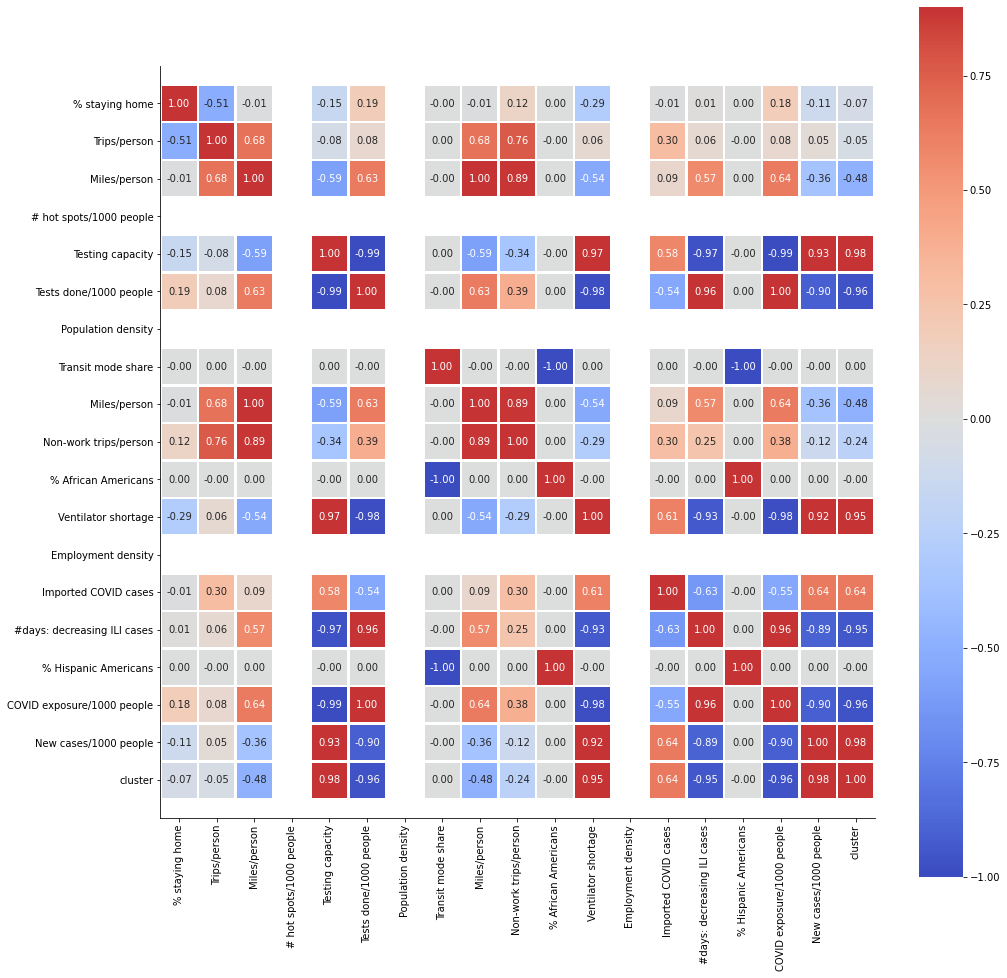

In [ ]:
corr = gmm_df.corr()
g = sns.heatmap(corr, vmax=.9, center=0,
               square=True, linewidths=1.5, cbar_kws={"shrink": .8}, annot=True, fmt='.2f', cmap='coolwarm')
bottom, top = g.get_ylim()
g.set_ylim(bottom + 0.5, top - 0.5)
sns.despine()
g.figure.set_size_inches(16, 20)